In [1]:
"""
Pairwise registration evaluation with meanshift filter denoising for both affine and deformable registration.
"""
import sys
sys.path.append('..')
sys.path.append('../../spami/')
import time

import json
import os
from os.path import join, exists
import shutil

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from greedyfhist.registration import GreedyFHist, get_default_args
from greedyfhist.options import Options
from greedyfhist.utils.metrics import compute_tre



from miit.reg_graph import RegGraph
from miit.utils.utils import create_if_not_exists, clean_configs

# from miit.utils.metrics import compute_tre, compute_tre_sections_

def get_core_names():
    return [x.split('.')[0] for x in os.listdir('../../spami/configs/cores_hr/')]


def main():
    skip_processed_cores = True
    root_dir = '../save_directories/pairwise_analysis/greedy_f_hist_params_sigma_test2'
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)
    core_names = get_core_names()
    df_all = pd.DataFrame()
    # resolutions = [1024]
    registerer = GreedyFHist(path_to_greedy='/mnt/work/workbench/maximilw/applications/test/greedy/build2/greedy')
    core_name = '048_01'
    config_path = os.path.join('../../spami/configs/cores_hr/', core_name + '.json')
    with open(config_path, 'r') as f:
        config = json.load(f)
        config = clean_configs(config)
        # config = filter_node_ids(config, section_ids)
    graph = RegGraph.from_config(config)        
    source_section = graph.sections[2].copy()
    target_section = graph.sections[3].copy()
    sigma1s = np.linspace(10, 150, 15)
    sigma2s = np.linspace(10, 150, 15)
    df = pd.DataFrame()
    for s1 in sigma1s:
        for s2 in sigma2s:
            options = Options()
            options.greedy_opts.n_threads = 32
            options.greedy_opts.s1 = s1
            options.greedy_opts.s2 = s2
            start = time.time()
            output_dir = 'save_directories/temp_nb/'
            temp_dir = 'save_directories/temp_nb/temp'
            options.output_directory = output_dir
            options.temporary_directory = temp_dir
            # args['output_dir'] = output_dir

            if exists(options.output_directory):
                shutil.rmtree(options.output_directory)
            create_if_not_exists(options.output_directory)
            registration_result = registerer.register(moving_img=source_section.image.data,
                                                      fixed_img=target_section.image.data,
                                                      moving_img_mask=source_section.segmentation_mask.data,
                                                      fixed_img_mask=target_section.segmentation_mask.data,
                                                      options=options)
            end = time.time()
            transformation_result = registerer.transform_pointset(source_section.landmarks.data, registration_result)
            warped_pointset = transformation_result.final_transform.pointcloud
            warped_pointset['label'] = source_section.landmarks.data.label
            target_pointset = target_section.landmarks.data
            shape = target_section.image.data.shape
            mean_rtre, median_rtre, mean_tre, median_tre = compute_tre(target_pointset, warped_pointset, shape)            
            duration = end - start
            row = {
                'core_name': core_name,
                'fixed_section_id': fi,
                'moving_section_id': 2,
                'mean_rtre': mean_rtre,
                'median_rtre': median_rtre,
                'mean_tre': mean_tre,
                'median_tre': median_tre,
                'duration': duration,
                's1': s1,
                's2': s2,
            }
            row = pd.DataFrame(row, index=[0])
            df = pd.concat([df, row]).reset_index(drop=True)
            print(row)
            print(f'Duration: {duration}.')
    df.to_csv(join(root_dir, 'stats.csv'))


# if __name__ == '__main__':
#     main()


In [23]:
skip_processed_cores = True
root_dir = '../save_directories/pairwise_analysis/greedy_f_hist_params_sigma_test2'
if not os.path.exists(root_dir):
    os.mkdir(root_dir)
core_names = get_core_names()
df_all = pd.DataFrame()
# resolutions = [1024]
registerer = GreedyFHist.load_from_config({'path_to_greedy': '/mnt/work/workbench/maximilw/applications/test/greedy/build2'})
core_name = '001_01'
config_path = os.path.join('../../spami/configs/cores_hr/', core_name + '.json')
with open(config_path, 'r') as f:
    config = json.load(f)
    config = clean_configs(config)
    # config = filter_node_ids(config, section_ids)
graph = RegGraph.from_config(config)        
# source_section = graph.sections[2].copy()
# target_section = graph.sections[3].copy()


In [24]:
source_section = graph.sections[1]
target_section = graph.sections[2]

In [25]:
reg_result = registerer.register(source_section.image.data,
                                 target_section.image.data)

In [26]:
transformation_result = registerer.transform_image(source_section.image.data, reg_result, 'LINEAR')

In [8]:
import onnxruntime as ort

In [9]:
model = ort.InferenceSession('../greedyfhist/model_data/segmentation/default_yolo.onnx')

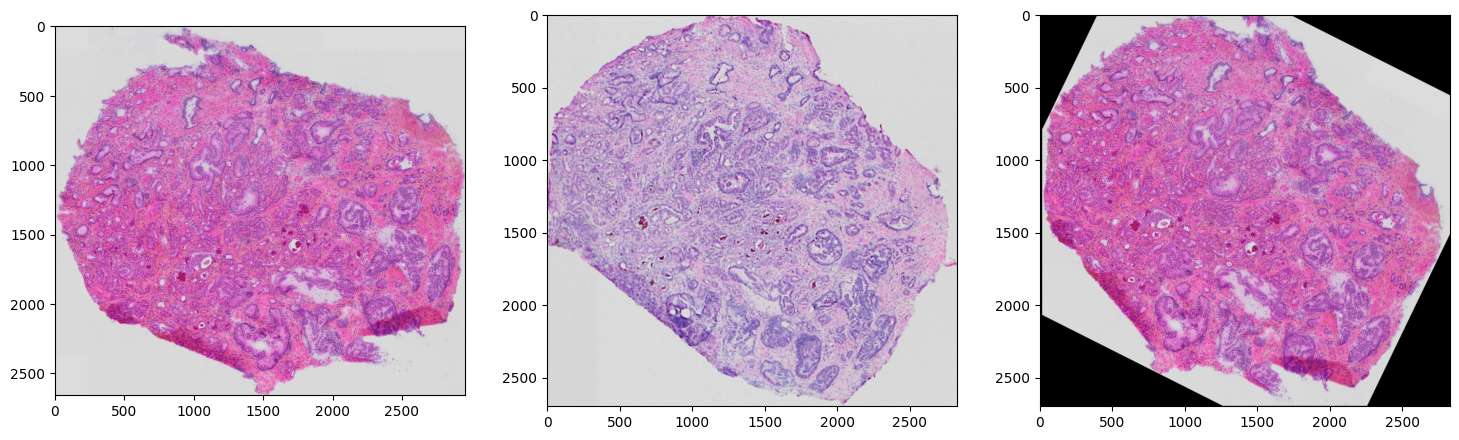

In [27]:
warped_image = transformation_result.final_transform.registered_image
_, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(source_section.image.data)
axs[1].imshow(target_section.image.data)
axs[2].imshow(warped_image)

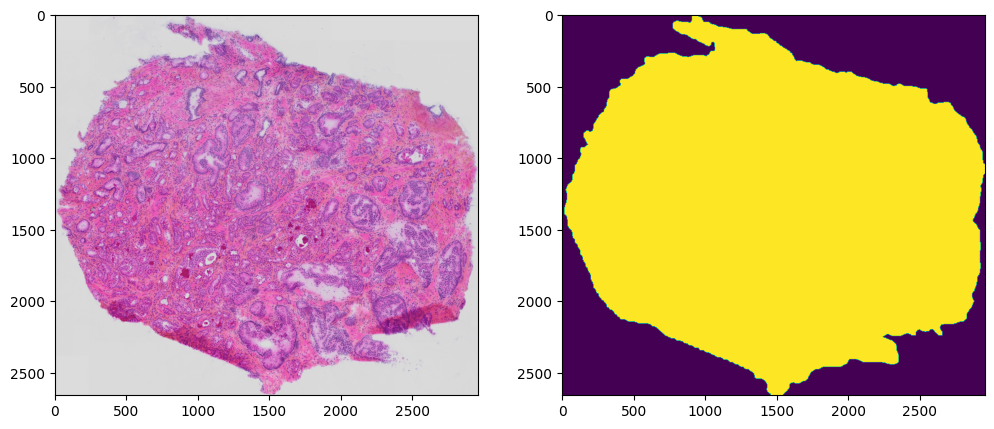

In [9]:
_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(img)
axs[1].imshow(mask)

In [3]:
image_mask_list = [
    (graph.sections[2].image.data, graph.sections[2].segmentation_mask.data),
    (graph.sections[3].image.data, graph.sections[3].segmentation_mask.data),
    (graph.sections[6].image.data, graph.sections[6].segmentation_mask.data),
]

In [4]:
reg_result = registerer.register_multi_image(image_mask_list)

In [6]:
image_transformation_result = registerer.transform_image(graph.sections[2].image.data, reg_result, 'LINEAR')

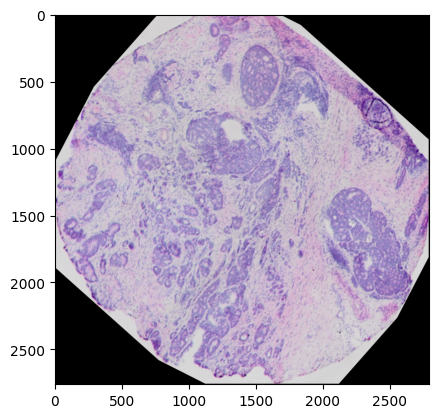

In [7]:
warped_image = image_transformation_result.final_transform.registered_image
plt.imshow(warped_image)

In [8]:
s1 = 6
s2 = 5

options = Options()
options.greedy_opts.n_threads = 32
options.greedy_opts.s1 = s1
options.greedy_opts.s2 = s2
options.deformable_do_denoising=False
options.affine_do_denoising=True
output_dir = 'save_directories/temp_nb/'
temp_dir = 'save_directories/temp_nb/temp'
options.output_directory = output_dir
options.temporary_directory = temp_dir
options.remove_temporary_directory = False
options.greedy_opts.cost_function = 'wncc'

In [5]:
options

Options(greedy_opts=GreedyOptions(dim=2, s1=6, s2=5, kernel_size=10, cost_function='wncc', iteration_rigid=10000, ia='ia-com-init', pyramid_iterations=[100, 50, 10], n_threads=32, use_sv=False, use_svlb=False), resolution=(1024, 1024), kernel_size=10, output_directory='save_directories/temp_nb/', temporary_directory='save_directories/temp_nb/temp', affine_do_registration=True, deformable_do_registration=True, affine_do_denoising=True, deformable_do_denoising=False, moving_sr=30, moving_sp=25, fixed_sr=30, fixed_sp=25, pre_downsampling_factor=1, store_cmdline_returns=True, remove_temporary_directory=False)

In [9]:
# output_dir = 'save_directories/temp_nb/'
# temp_dir = 'save_directories/temp_nb/temp'
# options.output_directory = output_dir
# options.temporary_directory = temp_dir
# options.remove_temporary_directory = False
# args['output_dir'] = output_dir

# options.affine_do_denoising = False
# options.deformable_do_denoising = False
if exists(options.output_directory):
    shutil.rmtree(options.output_directory)
create_if_not_exists(options.output_directory)
registration_result = registerer.register(moving_img=source_section.image.data,
                                          fixed_img=target_section.image.data,
                                          moving_img_mask=source_section.segmentation_mask.data,
                                          fixed_img_mask=target_section.segmentation_mask.data,
                                          options=options)
# end = time.time()


In [10]:
transformation_result = registerer.transform_pointset(source_section.landmarks.data, registration_result)
# warped_pointset = transformation_result.final_transform.pointcloud
# warped_pointset['label'] = source_section.landmarks.data.label
# target_pointset = target_section.landmarks.data
# shape = target_section.image.data.shape
# mean_rtre, median_rtre, mean_tre, median_tre = compute_tre(target_pointset, warped_pointset, shape)            
# # duration = end - start
# row = {
#     'core_name': core_name,
#     'fixed_section_id': 3,
#     'moving_section_id': 2,
#     'mean_rtre': mean_rtre,
#     'median_rtre': median_rtre,
#     'mean_tre': mean_tre,
#     'median_tre': median_tre,
#     # 'duration': duration,
#     's1': s1,
#     's2': s2,
# }
# # row = pd.DataFrame(row, index=[0])
# # df = pd.concat([df, row]).reset_index(drop=True)
# # print(row)
# # print(f'Duration: {duration}.')
# # df.to_csv(join(root_dir, 'stats.csv'))

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default b

In [17]:
warped_pointset = transformation_result.final_transform.pointcloud.copy()

In [18]:
idxs = warped_pointset.x > 0

In [16]:
warped_pointset.x.loc[idxs] = np.inf

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
warped_pointset.loc[idxs, 'x'] = np.inf

2 1 no no 33
2 1 yes yes 31

In [33]:
transformation_image_result = registerer.transform_image(source_section.image.data, registration_result, 'LINEAR')
warped_image= transformation_image_result.final_transform.registered_image


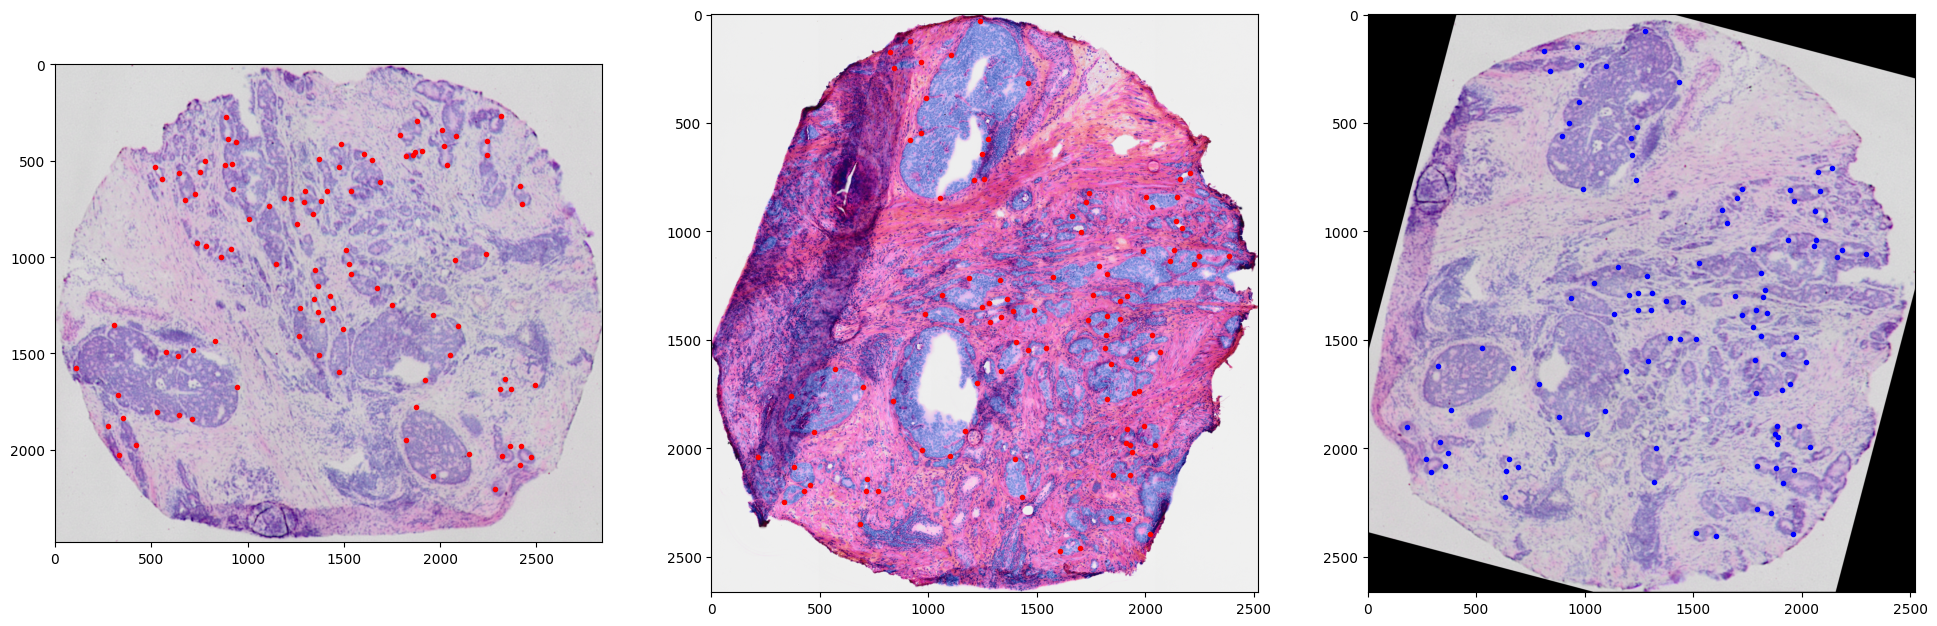

In [34]:
_, axs = plt.subplots(1, 3, figsize=(24, 8))
axs[0].imshow(source_section.image.data)
axs[0].plot(source_section.landmarks.data.x, source_section.landmarks.data.y, 'r.')
axs[1].imshow(target_section.image.data)
axs[1].plot(target_section.landmarks.data.x, target_section.landmarks.data.y, 'r.')
axs[2].imshow(warped_image)
axs[2].plot(warped_pointset.x, warped_pointset.y, 'b.')

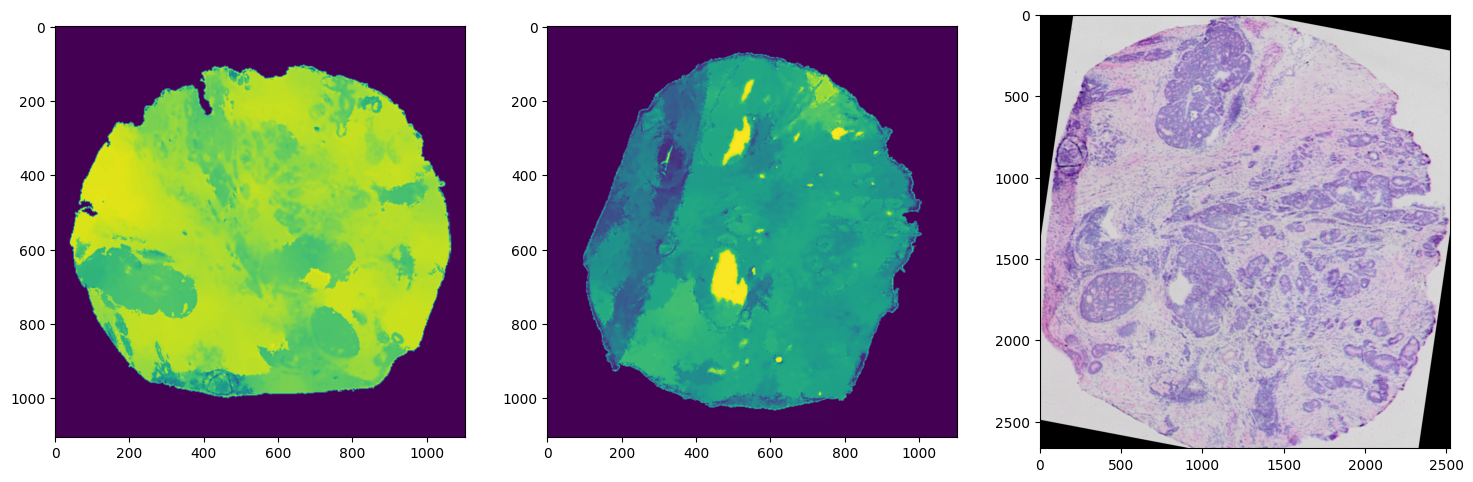

In [36]:
mov_den = sitk.GetArrayFromImage(sitk.ReadImage('../save_directories/multisection_integration/direct/multistep_handover_1_step_test/004_04/3_2/tmp/moving_denoised/new_small_image.nii.gz'))
fix_den = sitk.GetArrayFromImage(sitk.ReadImage('../save_directories/multisection_integration/direct/multistep_handover_1_step_test/004_04/3_2/tmp/fixed_denoised/new_small_image.nii.gz'))
reg_img = sitk.GetArrayFromImage(sitk.ReadImage('../save_directories/multisection_integration/direct/multistep_handover_1_step_test/004_04/3_2/warped_section/image.nii.gz'))
 

_, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(mov_den)
axs[1].imshow(fix_den)
axs[2].imshow(reg_img)

In [496]:

def eucl(src, dst):
    return np.sqrt(np.square(src[:, 0] - dst[:, 0]) + np.square(src[:, 1] - dst[:, 1]))



In [497]:
warped_df = warped_pointset.copy()
fixed_df = target_section.landmarks.data.copy()
merged_df = warped_df.merge(fixed_df, on='label', suffixes=('_src', '_dst'))
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)
merged_df.dropna(inplace=True)
src_mat = merged_df[['x_src', 'y_src']].to_numpy()
dst_mat = merged_df[['x_dst', 'y_dst']].to_numpy()
merged_df['tre'] = eucl(src_mat, dst_mat)


In [498]:
pd.DataFrame(merged_df.iloc[7]).transpose()

x_src        y_src label Unnamed: 0       x_dst        y_dst       tre
7  251.373914  1655.023649  Pt-7          7  264.615267  1676.934116  25.60082

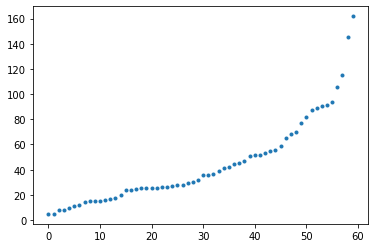

In [499]:
plt.plot(np.sort(merged_df.tre), '.')

In [476]:
merged_df.tre.max()

150.29796035178646

In [477]:
warped_df.shape, fixed_df.shape, merged_df.shape

((68, 3), (68, 4), (60, 7))

In [478]:
def plot_sections_with_landmark_distance(image, unified_lms):
    plt.imshow(image)
    plt.title('Warped Image')
    plt.axis('off')
    for idx, row in unified_lms.iterrows():
        x1 = row['x_src']
        y1 = row['y_src']
        x2 = row['x_dst']
        y2 = row['y_dst']
        plt.plot(x1, y1, 'b.')
        plt.plot(x2, y2, 'g.')
        x_values = [x1, x2]
        y_values = [y1, y2]
        plt.plot(x_values, y_values, 'k', linestyle="-")

In [479]:
temp_df = merged_df.copy()
temp_df = temp_df[temp_df.tre == temp_df.tre.max()]
# temp_df = pd.DataFrame(merged_df.iloc[7]).transpose()
temp_df

x_src        y_src label  Unnamed: 0       x_dst        y_dst  \
1  526.696076  1847.343142  Pt-1           1  395.518668  1920.705015   

         tre  
1  150.29796

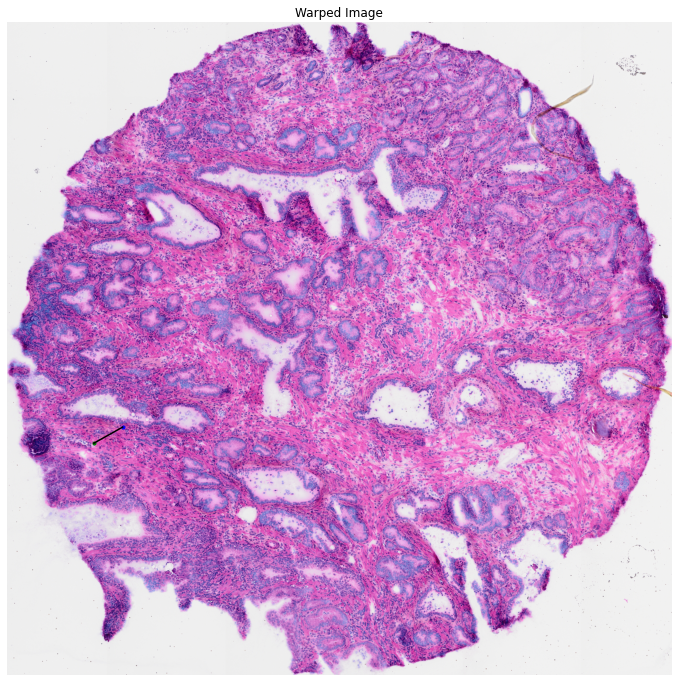

In [480]:
plt.figure(figsize=(12, 12,))
plot_sections_with_landmark_distance(target_section.image.data, temp_df)

In [375]:
import SimpleITK as sitk

In [340]:
options.temporary_directory

'save_directories/temp_nb/temp'

In [341]:
bw2 = sitk.ReadImage('save_directories/temp_nb/registrations/0/metrics/full_resolution/big_warp.nii.gz')
bw2

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fa754c52d50> >

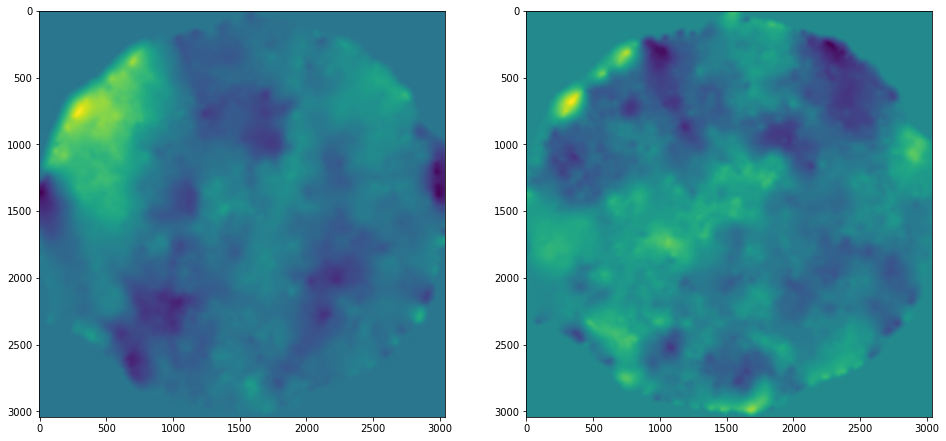

In [342]:
bw_arr2 = sitk.GetArrayFromImage(bw2)
bw_raw21 = bw_arr2[:,:,0]
bw_raw22 = bw_arr2[:,:,1]
_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(bw_raw21)
axs[1].imshow(bw_raw22)

In [407]:
bw = sitk.ReadImage('save_directories/temp_nb/registrations/0/metrics/full_resolution/big_warp.nii.gz')
bw

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x7fa62ceec990> >

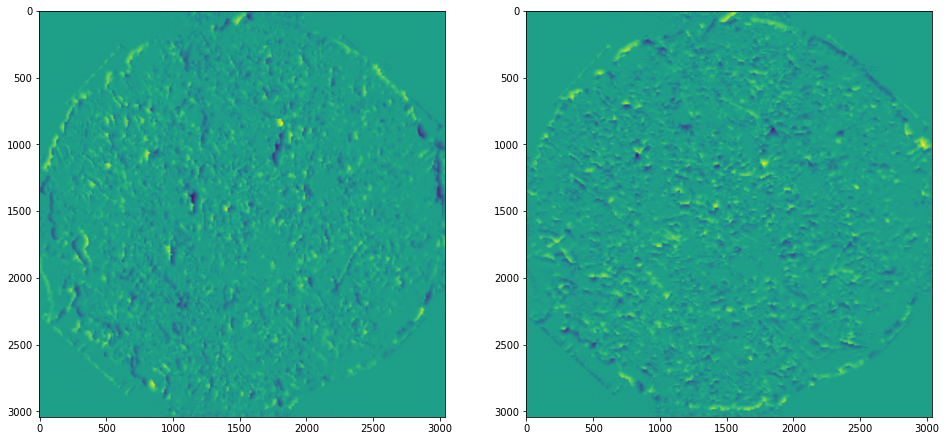

In [408]:
bw_arr = sitk.GetArrayFromImage(bw)
bw_raw1 = bw_arr[:,:,0]
bw_raw2 = bw_arr[:,:,1]
_, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(bw_raw1)
axs[1].imshow(bw_raw2)

In [238]:
np.unique(bw_raw1).shape

(59331,)

In [218]:
(bw_raw21 != bw_raw1).sum()

7369999

In [214]:
registration_result.reg_results[0].reg_params

{'s1': 6,
 's2': 5,
 'iteration_rigid': 10000,
 'resolution': (1024, 1024),
 'affine_use_denoising': False,
 'deformable_use_denoising': False,
 'options': {'greedy_opts': {'dim': 2,
   's1': 6,
   's2': 5,
   'kernel_size': 10,
   'cost_function': 'ncc',
   'iteration_rigid': 10000,
   'ia': 'ia-com-init',
   'pyramid_iterations': [100, 50, 10],
   'n_threads': 32,
   'use_sv': False,
   'use_svlb': False},
  'resolution': (1024, 1024),
  'kernel_size': 10,
  'output_directory': 'save_directories/temp_nb/',
  'temporary_directory': 'save_directories/temp_nb/temp',
  'affine_do_registration': True,
  'deformable_do_registration': True,
  'affine_do_denoising': False,
  'deformable_do_denoising': False,
  'moving_sr': 30,
  'moving_sp': 20,
  'fixed_sr': 30,
  'fixed_sp': 20,
  'pre_downsampling_factor': 1,
  'store_cmdline_returns': True,
  'remove_temporary_directory': False},
 'pre_downsampling_factor': 1,
 'original_moving_image_size': (2997, 3018, 3),
 'original_fixed_image_size': 

In [182]:
registration_result.reg_results[0].reg_params

{'s1': 130,
 's2': 120,
 'iteration_rigid': 10000,
 'resolution': (1024, 1024),
 'affine_use_denoising': False,
 'deformable_use_denoising': False,
 'options': {'greedy_opts': {'dim': 2,
   's1': 130,
   's2': 120,
   'kernel_size': 10,
   'cost_function': 'ncc',
   'iteration_rigid': 10000,
   'ia': 'ia-com-init',
   'pyramid_iterations': [100, 50, 10],
   'n_threads': 32,
   'use_sv': False,
   'use_svlb': False},
  'resolution': (1024, 1024),
  'kernel_size': 10,
  'output_directory': 'save_directories/temp_nb/',
  'temporary_directory': 'save_directories/temp_nb/temp',
  'affine_do_registration': True,
  'deformable_do_registration': True,
  'affine_do_denoising': False,
  'deformable_do_denoising': False,
  'moving_sr': 30,
  'moving_sp': 20,
  'fixed_sr': 30,
  'fixed_sp': 20,
  'pre_downsampling_factor': 1,
  'store_cmdline_returns': True,
  'remove_temporary_directory': False},
 'pre_downsampling_factor': 1,
 'original_moving_image_size': (2997, 3018, 3),
 'original_fixed_image

In [215]:
print(registration_result.reg_results[0].cmdl_log[-1].stdout.decode('utf-8'))

Limiting the number of threads to 32
Smooth dir 0 Sigma 2 Dim 1104
Smooth dir 1 Sigma 2 Dim 1104
Smooth dir 0 Sigma 1 Dim 1104
Smooth dir 1 Sigma 1 Dim 1104
Smooth dir 0 Sigma 2 Dim 1104
Smooth dir 1 Sigma 2 Dim 1104
Smooth dir 0 Sigma 1 Dim 1104
Smooth dir 1 Sigma 1 Dim 1104
LEVEL 1 of 3
  Smoothing sigmas (mm): 24.000000x24.000000 20.000000x20.000000
Level 000  Iter 00000    Energy = 0.447542
Level 000  Iter 00001    Energy = 0.467096
Level 000  Iter 00002    Energy = 0.485855
Level 000  Iter 00003    Energy = 0.491984
Level 000  Iter 00004    Energy = 0.490683
Level 000  Iter 00005    Energy = 0.491269
Level 000  Iter 00006    Energy = 0.490621
Level 000  Iter 00007    Energy = 0.490257
Level 000  Iter 00008    Energy = 0.490044
Level 000  Iter 00009    Energy = 0.489780
Level 000  Iter 00010    Energy = 0.489911
Level 000  Iter 00011    Energy = 0.489817
Level 000  Iter 00012    Energy = 0.490272
Level 000  Iter 00013    Energy = 0.490332
Level 000  Iter 00014    Energy = 0.490942


In [192]:
print(registration_result.reg_results[0].cmdl_log[-1].stdout.decode('utf-8'))

Limiting the number of threads to 32
Smooth dir 0 Sigma 2 Dim 1104
Smooth dir 1 Sigma 2 Dim 1104
Smooth dir 0 Sigma 1 Dim 1104
Smooth dir 1 Sigma 1 Dim 1104
Smooth dir 0 Sigma 2 Dim 1104
Smooth dir 1 Sigma 2 Dim 1104
Smooth dir 0 Sigma 1 Dim 1104
Smooth dir 1 Sigma 1 Dim 1104
LEVEL 1 of 3
  Smoothing sigmas (mm): 520.000000x520.000000 480.000000x480.000000
Level 000  Iter 00000    Energy = 0.447970
Level 000  Iter 00001    Energy = 0.360815
Level 000  Iter 00002    Energy = 0.432216
Level 000  Iter 00003    Energy = 0.433702
Level 000  Iter 00004    Energy = 0.435805
Level 000  Iter 00005    Energy = 0.434682
Level 000  Iter 00006    Energy = 0.437400
Level 000  Iter 00007    Energy = 0.434738
Level 000  Iter 00008    Energy = 0.437475
Level 000  Iter 00009    Energy = 0.434458
Level 000  Iter 00010    Energy = 0.437571
Level 000  Iter 00011    Energy = 0.434407
Level 000  Iter 00012    Energy = 0.437574
Level 000  Iter 00013    Energy = 0.434384
Level 000  Iter 00014    Energy = 0.437

In [517]:
core_name = '046_01'
config_path = os.path.join('../../spami/configs/cores_hr/', core_name + '.json')
with open(config_path, 'r') as f:
    config = json.load(f)
    config = clean_configs(config)
    # config = filter_node_ids(config, section_ids)
graph = RegGraph.from_config(config) 

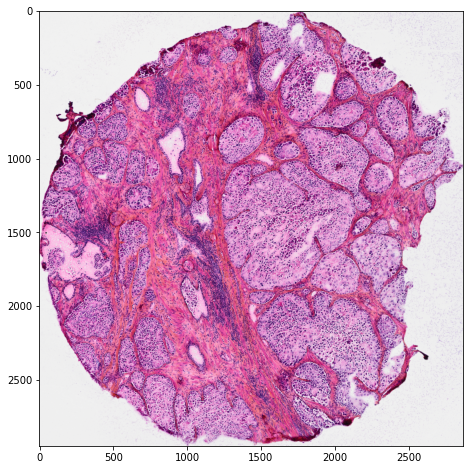

In [520]:
plt.figure(figsize=(8,8))
plt.imshow(graph.sections[7].image.data)